In [1]:
import sys
print (sys.version)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from itertools import chain
import math
%matplotlib inline

3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]



# Project WP1-2
### code 2: Display, and group ports
<span style='font-family:"Times New Roman"'> <span styel=''> 
This code is used to group terminals by given radius (e.g., 100 nm), and to add extra features "Port" and "Region".
The working datset in this sheet is "PortList.csv";
### Basic steps: 
    a) Load data;
    b) 
    c) 
    d) 
    e) Save the cleaned dataset

###  Step a) : Load data, and display ports info in geographic map

In [13]:
df_ports=pd.read_csv("C:/posDoc-SDU-Denmark/SDU_research/shippingLabwp1/portsInfo.csv")
print (df_ports.info())
print ("----------------------------------------------------------------------------------------------------------------------")
print ("The statistic information of portsInfor:\n")
print (df_ports.describe().T)
print ("----------------------------------------------------------------------------------------------------------------------")
print ("The shape of portsInfo file:",df_ports.shape)
print ("----------------------------------------------------------------------------------------------------------------------")
print ("The features names of portsInfor:\n",df_ports.columns.to_list())
print ("----------------------------------------------------------------------------------------------------------------------")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3288 entries, 0 to 3287
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Terminal              3288 non-null   object 
 1   Country               3288 non-null   object 
 2   Lat                   3288 non-null   float64
 3   Lon                   3288 non-null   float64
 4   number of call start  3288 non-null   float64
 5   number of call end    3288 non-null   float64
 6   number of call all    3288 non-null   float64
dtypes: float64(5), object(2)
memory usage: 179.9+ KB
None
----------------------------------------------------------------------------------------------------------------------
The statistic information of portsInfor:

                       count        mean         std        min        25%  \
Lat                   3288.0   22.971758   25.946251  -53.27303   6.957058   
Lon                   3288.0   21.931035   78.278837 -171.7

In [14]:
df_ports.head()

,Terminal,Country,Lat,Lon,number of call start,number of call end,number of call all
0,Singapore,Singapore,1.20470,103.67232,7403.0,7365.0,14768.0
1,PTP Terminal,Russia,60.32058,28.72898,3785.0,3781.0,7566.0
2,Novorossiysk,Russia,44.72680,37.78154,3762.0,3762.0,7524.0
3,Yeosu,South Korea,34.71473,127.81125,3531.0,3547.0,7078.0
4,Houston,United States of America,29.23550,-94.62350,3371.0,3375.0,6746.0


### display ports data

In [19]:
def draw_map(m, scale=0.5):
    """
    plot backgroud map
    m: Basemap object
    scale: plot scale
    
    return: plot a backgroud map
    """
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    #m.bluemarble(scale=scale)  #Project NASA's blue marble image onto the map
    #m.drawcoastlines()
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

def check_valsCount(df):
    """
    Check values counts in given dataframe
    return: counts of each column in given dataframe
    """
    cols=df.columns
    counts_all=[]
    for col in cols:
        counts=df.loc[:,col].value_counts()
        counts_all.append(counts)
        print (counts)
        print ('\n')
    return counts_all

Dutch Harbor                           1
Krishnapatnam Coal Terminal            1
Iraklion                               1
Grain Bulk Handlers Terminal           1
Setubal                                1
                                      ..
Longxue                                1
Durban Point Multi-Purpose Terminal    1
Kordin Grain Terminal                  1
Union Oil Terminal                     1
CUFL Jetty                             1
Name: Terminal, Length: 3288, dtype: int64


----------------------------------------------------------------------------------------------------------------------
No duplicate terminals any more !
----------------------------------------------------------------------------------------------------------------------
The respective minimum and maximum latitude and longitude coordiates of ports are: (-53.27303000000001, 76.55333, -171.7624, 179.36674)


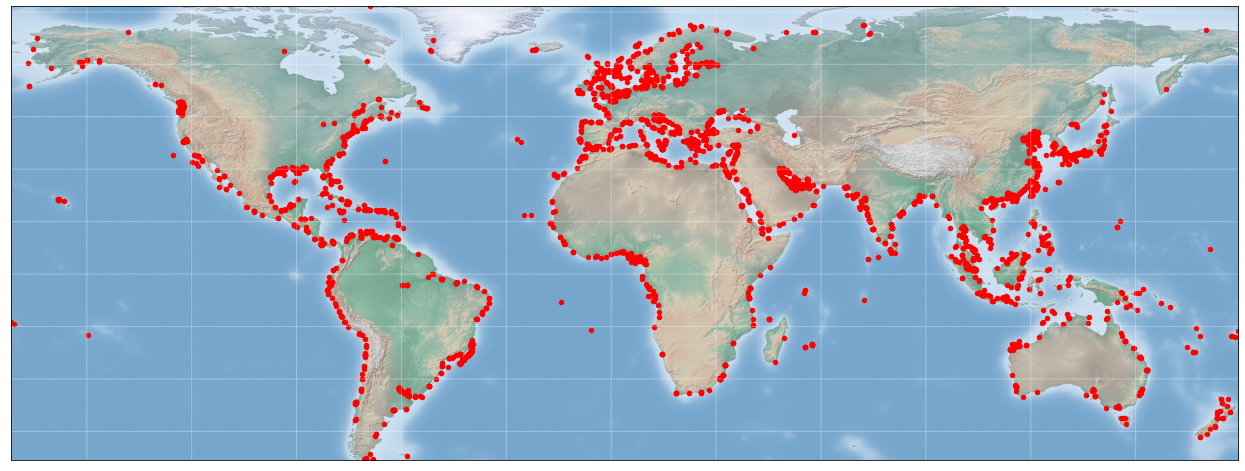

In [20]:
# Check terminal duplicates
df_terminal=pd.DataFrame(df_ports.Terminal)
counts_all=check_valsCount(df_terminal)
print ("----------------------------------------------------------------------------------------------------------------------")
print ("No duplicate terminals any more !")
print ("----------------------------------------------------------------------------------------------------------------------")

# visulize original ports 
bbox=(df_ports.Lat.min(),df_ports.Lat.max(),df_ports.Lon.min(),df_ports.Lon.max())                                                        
print ("The respective minimum and maximum latitude and longitude coordiates of ports are:",bbox)

fig,ax=plt.subplots(figsize=(22,14))
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=bbox[0], urcrnrlat=bbox[1],
            llcrnrlon=bbox[2], urcrnrlon=bbox[3])
ax.scatter(df_ports.Lon,df_ports.Lat,zorder=1, alpha= 1, c='r', s=20)
draw_map(m)

ax.set_xlim(bbox[2],bbox[3]);
ax.set_ylim(bbox[0],bbox[1]);
fig.savefig("C:/posDoc-SDU-Denmark/SDU_research/shippingLabwp1/portsOriginal_1.png",dpi=400)

### Step b):  Calculate location distance, and group terminals

In [21]:
def dist(lat1,lat2,lon1,lon2):
    """
    compute the great-circle distance between two locations on earth.
    lat1,lon1: location information of location 1; in degrees
    lat2,lon2: location information of location 2; in degrees
    
    return: numeric; distance, in km
    """ 
    from math import radians, cos, sin, asin,sqrt
    R=6371  # km
    
    #  turn to radias
    lon1=radians(lon1) 
    lon2=radians(lon2)
    lat1=radians(lat1)
    lat2=radians(lat2)
    
    # Haversine formula
    dlon=lon2-lon1
    dlat=lat2-lat1
    a=sin(dlat/2)**2+cos(lat1)*cos(lat2)*sin(dlon/2)**2
    
    c = 2 * asin(sqrt(a))
    d=R*c # km
    return d

def similar_terminal(df, ix1, lat1, lon1,dist_ref=100 * 1.852):
    """
    Given a location (ix1,lat1, lon1), compute the distance between this single location and all other locations in dataframe.
    Then, extract all the ids of similar terminals when dist is not larger than dist_ref.
    
    df:dataFrame
    ix1,lat1,lon1: index of each row, latitude, longitude
    dist_ref: reference distance,the default is 185.2km
    return:ids dict; terminals dict
    """
    similars_ids_single = {}
    similars_terminals_single = {}

    # remove the original location itself
    df_update = df.drop([ix1], axis=0)

    # loop to find the suitable ids
    for ix2, lat2, lon2 in zip(df_update.index, df_update.Lat, df_update.Lon):
        dist_temp = dist(lat1, lat2, lon1, lon2)
        if dist_temp <= dist_ref:
            similars_ids_single.setdefault(ix1, []).append(ix2)
            similars_terminals_single.setdefault(df.loc[ix1, 'Terminal'], []).append(df.loc[ix2, 'Terminal'])
            # similars_ids_single.append(ind2)
            # similars_terminals_single.append(df.loc[ind2,'Terminal'])

    if (similars_ids_single!=None) and  (similars_terminals_single!=None):
        return similars_ids_single, similars_terminals_single
    return None

def similar_terminals(df):
    """
    compute all similar terminals, given a dataframe
    Add them into a dictionary for further utilization.
    
    return: a list including all similar terminals for every terminal in given dataframe
    """
    similars_ids_all = []
    similars_terminals_all = []

    for id1, lat1, lon1 in zip(df.index, df.Lat, df.Lon):
        temp_id, temp_terminals = similar_terminal(df, id1, lat1, lon1)
        similars_ids_all.append(temp_id)
        similars_terminals_all.append(temp_terminals)
    return similars_ids_all, similars_terminals_all

def groupSame(df,portCommon="Rio Cullen",group_id=[1231,1556, 1687, 1897, 1934],sortValue="number of call all"):
    """
    Group dataframe with given idx, and sort it in a descend way.
    sorted the dataframe by sortValue in a descend way
    
    df: dataframe
    portCommon: string, terminal used as the common port name of a group of close terminals
    group_id: list; index of all the similar terminals,including portCommon itself. 
    sortValue: string, used for sorting of dataframe
    """
    df_similar=df_ports.loc[group_id]
    df_similar.sort_values(axis=0,by=[sortValue],ascending=False,inplace=True)
    return df_similar

# # test case for dist() function
# lat1,lat2=53.32055555555556,53.31861111111111
# long1,long2=-1.7297222222222221,-1.6997222222222223
# d=dist(lat1,lat2,long1,long2)
# print (d)

In [22]:
# test case for similar_terminal()
similars_ids_single,similars_terminals_single=similar_terminal(df_ports,1231,-52.81843,-68.16315)
print (df_ports[df_ports.Terminal=="Rio Cullen"])
print ("----------------------------------------------------------------------------------------------------------------------")
print ("the similar terminals ids as terminal 'Rio Cullen' id are:",similars_ids_single)
print ("----------------------------------------------------------------------------------------------------------------------")
print ("the similar terminals as terminal 'Rio Cullen' are:",similars_terminals_single)

# compute all similar termilars in df_ports
similars_ids_all,similars_terminals_all=similar_terminals(df_ports)
print ("----------------------------------------------------------------------------------------------------------------------")
print ("The name of all similar terminals (first 2 items):",similars_terminals_all[:1])
print ("----------------------------------------------------------------------------------------------------------------------")
print ("the ids of all the similar terminals are:",similars_ids_all[:1])
print ("----------------------------------------------------------------------------------------------------------------------")

the similar terminals ids as terminal 'Rio Cullen' id are: {1231: [1556, 1687, 1897, 1934]}
----------------------------------------------------------------------------------------------------------------------
the similar terminals as terminal 'Rio Cullen' are: {'Rio Cullen': ['San Sebastian', 'Puerto Sara', 'Cabo Negro Gas Terminal', 'Punta Loyola']}
----------------------------------------------------------------------------------------------------------------------
The name of all similar terminals (first 2 items): [{'Singapore': ['Oiltanking Singapore Terminal', 'Universal Oil Terminal', 'ExxonMobil Terminal', 'Vopak Sebarok Terminal', 'Tanjung Bin', 'Vopak Banyan Terminal', 'Pulau Busing Terminal', 'Horizon Singapore Terminal', 'TLP Liquid Cargo Terminal', 'Pulau Bukom Refinery', 'Pengerang Deepwater Terminal', 'SRC Terminal', 'Pasir Gudang Edible Oil Terminal', 'Tanjung Pelepas', 'Seraya Power Station Terminal', 'Pasir Gudang Non-Edible Liquid Terminal', 'Oiltanking Helios Termi

In [59]:
df_similar=groupSame(df_ports)
df_similar.head(10)

,Terminal,Country,Lat,Lon,number of call start,number of call end,number of call all
1231,Rio Cullen,Argentina,-52.81843,-68.16315,57.0,56.0,113.0
1556,San Sebastian,Argentina,-53.27303,-68.21175,29.0,29.0,58.0
1687,Puerto Sara,Chile,-52.64162,-70.18605,22.0,21.0,43.0
1897,Cabo Negro Gas Terminal,Chile,-52.92978,-70.80168,14.0,14.0,28.0
1934,Punta Loyola,Argentina,-51.60504,-69.01708,13.0,14.0,27.0
